In [1]:
from youtubeAPI import get_youtube_api_json
from pymongo import MongoClient # you should install dnspython also
from utils import ProgressBar
from youtubesearchpython import *
from pprint import pprint
from preprocess import preprocessVideoData
import seaborn as sns
from scipy.stats import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import datetime

with open("apikey.txt", encoding="utf8") as f:
    apikey1 = f.readline().strip()
    apikey2 = f.readline().strip()

with open("mongodb.txt") as f:
    mongodb_uri = f.readline().strip()

client = MongoClient(mongodb_uri)
db = client["youtube"]
searchData = db["searchData"]

In [ ]:
videosSearch = VideosSearch("")
pprint(videosSearch.result())

In [ ]:
suggestionData = db["suggestionData"]
suggestions = Suggestions(language="kr", region="KR")

In [ ]:
hangul = re.compile("[^가-힣]+")

In [ ]:
total_data = set()
# for i in range(44032, 55216):
start, end = 54000, 55216
error_count = 0
bar = ProgressBar(end - start)
for i in range(start, end):
    bar.next()
    total_data.add(chr(i))
    try:
        data = suggestions.get(chr(i), mode=ResultMode.dict)
        for j in data["result"]:
            if len(hangul.findall(j)) == 0:
                total_data.add(j)
    except:
        error_count += 1
total_data = list(total_data)
total_data.sort()
print(error_count, total_data)

In [ ]:
suggestionData.insert_one({"result": total_data})

In [ ]:
all_data = list(suggestionData.find())
finalSuggestionData = db["finalSuggestionData"]
total_search_data = set()
for data in all_data:
    for keyword in data["result"]:
        total_search_data.add(keyword)
total_search_data = list(total_search_data)
total_search_data.sort()
print(len(total_search_data))

In [ ]:
finalSuggestionData.drop()

In [ ]:
divide = 50
size = len(total_search_data) // divide + 1
for i in range(divide):
    finalSuggestionData.insert_one(
        {"id": i, "result": total_search_data[size * i : min(size * (i + 1), len(total_search_data))]}
    )

In [ ]:
Video.get("MhQKe-aERsU")

In [ ]:
finalSuggestionData = db["finalSuggestionData"]

for data_num in range(37, 50):
    # data_num = 8
    total = finalSuggestionData.find_one({"id": data_num})["result"]
    id_collection = set()
    bar = ProgressBar(len(total))
    error_count = 0
    for target in total:
        bar.next()
        customSearch = CustomSearch(target, "CAMSAhAB", language="kr", region="KR")
        while True:
            search_result = customSearch.result()["result"]
            if len(search_result) == 0:
                break
            for result in search_result:
                try:
                    viewCount = int(result["viewCount"]["text"].split(" views")[0].replace(",", ""))
                    if viewCount < 10**6:
                        break
                    id_collection.add(result["id"])
                except:
                    continue
            else:
                customSearch.next()
                continue
            break
    print("count:",data_num, error_count, len(id_collection))
    videoIdData = db["videoIdData"]
    videoIdData.insert_one({"id":data_num, "result": list(id_collection)})

In [ ]:
print(list(id_collection))

In [ ]:
duplicate_datas = list(videoIdData.find())
remove_duplicate = set()
for duplicate_data in duplicate_datas["result"]:
    for id in duplicate_data:
        remove_duplicate.add(id)
remove_duplicate = list(remove_duplicate)
finalVideoIdData = db["finalVideoIdData"]
divide = 50
size = len(remove_duplicate) // divide + 1
for i in range(divide):
    finalVideoIdData.insert_one(
        {"id": i, "result": remove_duplicate[size * i : min(size * (i + 1), len(remove_duplicate))]}
    )

In [ ]:
global_query = {"key": apikey1, "maxResults": 100, "regionCode": "KR"}


def get_video(query):
    final_query = {
        **global_query,
        **query,
        "part": "snippet, contentDetails, status, statistics, player, topicDetails, recordingDetails",
    }
    return get_youtube_api_json("videos", final_query)

In [ ]:
videoInfoData = db["videoInfoData"]
final_total_id = list(finalVideoIdData.find())
for ids in final_total_id["result"]:
    count = 0
    result = []
    while len(ids) > 50 * count:
        query = {"id": ",".join(ids[50 * count : min(50 * (count + 1), len(ids))])}
        result.extend(get_video(query).get("items", []))
        count += 1
    videoInfoData.insert_one({"result": result})

In [ ]:
finalVideoInfoData = db["finalVideoInfoData"]
videoInfoData = db["videoInfoData"]
init_data = list(videoInfoData.find({"id":0}))
preprocessed_data = []
for data in init_data[0]["result"]:
    pprint(data)
    break

In [ ]:
Video.get("SN-E6bO0Te0")

In [ ]:
get_video({"id":"SN-E6bO0Te0"})

In [ ]:
finalVideoInfoData = db["finalVideoInfoData"]
videoInfoData = db["videoInfoData"]
preprocessed_data = []
bar = ProgressBar(50)
for i in range(50):
    bar.next()
    init_data = videoInfoData.find_one({"id":i})
    for data in init_data["result"]:
            preprocessed_data.append(preprocessVideoData(data))

In [ ]:
len(preprocessed_data)

In [ ]:
from preprocess import isKoreanVideo
koreanVideo = []
for data in preprocessed_data:
    if isKoreanVideo(data):
        koreanVideo.append(data)
print(len(koreanVideo))

In [ ]:
finalVideoInfoData = db["finalVideoInfoData"]
finalVideoInfoData.insert_many(koreanVideo)

In [3]:
finalVideoInfoData = db["finalVideoInfoData"]
data = list(finalVideoInfoData.find())

df = pd.DataFrame(data)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175442 entries, 0 to 175441
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   _id                   175442 non-null  object        
 1   id                    175442 non-null  object        
 2   duration              175442 non-null  int64         
 3   caption               175442 non-null  bool          
 4   publishedAt           175442 non-null  datetime64[ns]
 5   channelId             175442 non-null  object        
 6   title                 175442 non-null  object        
 7   description           175442 non-null  object        
 8   channelTitle          175442 non-null  object        
 9   tags                  153214 non-null  object        
 10  categoryId            175442 non-null  int64         
 11  liveBroadcastContent  175442 non-null  bool          
 12  defaultAudioLanguage  121539 non-null  object        
 13 

In [4]:
print(len(df[df.commentCount.isnull()]))
print(len(df[df.commentCount==0]))
hasComment = df[df.commentCount.notnull() & df.commentCount != 0].copy()
print(len(hasComment))

6419
14164
154859


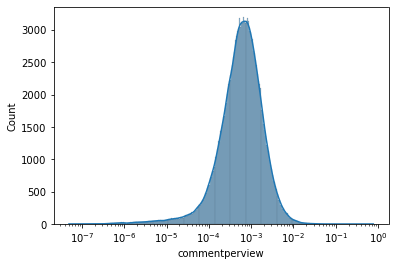

In [6]:
hasComment["commentperview"] = hasComment.commentCount/hasComment.viewCount
axes = sns.histplot(hasComment, x=hasComment.commentperview, log_scale=True, kde=True)

<AxesSubplot:xlabel='commentperview', ylabel='Count'>

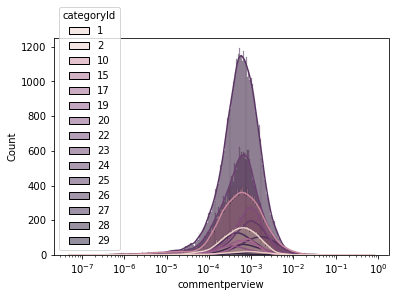

In [7]:
sns.histplot(hasComment, x=hasComment.commentperview, log_scale=True, kde=True, hue="categoryId")

In [ ]:
print(kstest(hasComment["commentperview"], 'norm', (0.0010069749358285341, 0.0024945284406088773)))
print(kstest(hasComment["commentperview"], 'lognorm', (1111231,1,2)))
loc, scale1 = norm.fit(hasComment["commentperview"])
shape, floc, scale2 = lognorm.fit(hasComment["commentperview"])
print(loc, scale1, shape, floc, scale2)

In [ ]:
s = 1
print(lognorm.ppf(0.01, s), lognorm.ppf(0.99, s))
# x = np.linspace(lognorm.ppf(0.01, s), lognorm.ppf(0.99, s), 100)
x = np.logspace(-1, 6, 100000)
print(lognorm.pdf([1,2,3], 1))
axes = sns.histplot(lognorm.pdf(x, s), log_scale=True)

In [ ]:
commentCount1 = hasComment.commentCount.tolist()
commentCount2 = hasComment[hasComment.viewCount>10000000].commentCount.tolist()*10
commentCount3 = hasComment[hasComment.viewCount>100000000].commentCount.tolist()*100
sns.histplot(commentCount1, log_scale=True,  kde=True)
sns.histplot(commentCount2, log_scale=True,  kde=True, color='g')
sns.histplot(commentCount3, log_scale=True,  kde=True, color="y")

In [ ]:
sns.histplot(hasComment, x=hasComment[hasComment.viewCount>10000000].commentCount, log_scale=True,  kde=True)

In [ ]:
sns.histplot(hasComment, x=hasComment[hasComment.viewCount>100000000].commentCount, log_scale=True,  kde=True)

In [ ]:
sns.histplot(hasComment, x=hasComment.viewCount, kde=True, log_scale=True)

In [ ]:
print(len(hasComment))

In [ ]:
df.info()
df[df.favoriteCount != 0]["favoriteCount"]

In [ ]:
import seaborn as sns

# r이 -1.0과 -0.7 사이이면, 강한 음적 선형관계,
# r이 -0.7과 -0.3 사이이면, 뚜렷한 음적 선형관계,
# r이 -0.3과 -0.1 사이이면, 약한 음적 선형관계,
# r이 -0.1과 +0.1 사이이면, 거의 무시될 수 있는 선형관계,
# r이 +0.1과 +0.3 사이이면, 약한 양적 선형관계,
# r이 +0.3과 +0.7 사이이면, 뚜렷한 양적 선형관계,
# r이 +0.7과 +1.0 사이이면, 강한 양적 선형관계

hasValues = df[df.commentCount.notnull() & df.commentCount != 0 & df.likeCount.notnull()][["viewCount", "commentCount", "likeCount"]].copy()
corr = hasValues.corr(method="pearson")
print(corr, sep="\n\n")
# sns.pairplot(hasValues[["viewCount", "commentCount", "likeCount", "favoriteCount"]])

In [ ]:
df[df.liveBroadcastContent][["title", "viewCount"]]

In [ ]:
print(len(df[df.liveBroadcastContent]))
print(len(df[~df.liveBroadcastContent]))
notLive = df[~df.liveBroadcastContent].copy()

In [ ]:
sns.histplot(notLive, x=notLive.duration, kde=True, log_scale=True)

In [ ]:
sns.histplot(df, x=df.publishedAt, kde=True)

In [ ]:
sns.histplot(df, x=df[df.publishedAt>=datetime.datetime(2022,1,1)].publishedAt, kde=True)

In [ ]:
def todaytime(data:datetime.datetime):
    return data.hour*3600 + data.minute*60 + data.second


primetime = df.publishedAt.copy().apply(lambda x:x.hour)
sns.histplot(primetime, bins=24)

In [4]:
print(len(df[df.tags.isnull()]))
hasTag = df[df.tags.notnull()].copy()

22228


In [8]:
from collections import Counter
total_tags = []
for tags in hasTag.tags:
    total_tags.extend(tags)
total_tag_counter = Counter(total_tags)
print(total_tag_counter.most_common(100))
# got IOPub data rate exceeded. error

[('먹방', 10083), ('장난감', 5535), ('kpop', 5483), ('애니메이션', 5379), ('yt:cc=on', 4625), ('mukbang', 4611), ('드라마', 4389), ('어린이', 4238), ('키즈', 4012), ('tvN', 3903), ('SBS', 3871), ('아이돌', 3770), ('MBC', 3708), ('예능', 3579), ('레전드', 3325), ('kids', 3213), ('유재석', 3157), ('asmr', 3131), ('ASMR', 3079), ('개그', 3042), ('Kpop', 3036), ('엠넷', 3030), ('꿀잼', 2898), ('코미디', 2835), ('KBS', 2805), ('유아', 2715), ('게임', 2700), ('웃긴영상', 2662), ('놀이', 2659), ('뽀로로', 2609), ('JTBC', 2609), ('Mnet', 2608), ('리얼사운드', 2597), ('음악', 2593), ('라이브', 2521), ('마인크래프트', 2497), ('교육', 2458), ('동요', 2353), ('toy', 2352), ('노래', 2342), ('한국', 2327), ('댄스', 2325), ('만화', 2284), ('toys', 2280), ('korea', 2244), ('디글', 2239), ('요리', 2157), ('영화', 2145), ('브이로그', 2131), ('방탄소년단', 2130), ('웃긴', 2118), ('마크', 2117), ('k-pop', 2109), ('케이팝', 2085), ('korean', 2080), ('가족', 2065), ('Diggle', 2049), ('KPOP', 1984), ('타요', 1955), ('뉴스', 1900), ('뮤비', 1898), ('몰카', 1895), ('animation', 1895), ('하하', 1875), ('토이', 1866), ('Kore

In [10]:
total_categories = []
for categories in df.topicCategories:
    total_categories.extend(categories)
total_category_counter = Counter(total_categories)
print(total_category_counter.most_common(100))

[('Lifestyle_(sociology)', 52848), ('Entertainment', 50560), ('Music', 40987), ('Music_of_Asia', 34442), ('Film', 27348), ('Pop_music', 25597), ('Food', 21162), ('Television_program', 14929), ('Hobby', 11159), ('Video_game_culture', 10685), ('Society', 7900), ('Action-adventure_game', 6839), ('Role-playing_video_game', 5560), ('Hip_hop_music', 5479), ('Action_game', 5432), ('Sport', 3723), ('Pet', 3556), ('Strategy_video_game', 3272), ('Electronic_music', 2642), ('Performing_arts', 2474), ('Vehicle', 2062), ('Politics', 1721), ('Physical_fitness', 1549), ('Technology', 1499), ('Association_football', 1297), ('Health', 1200), ('Knowledge', 1047), ('Rhythm_and_blues', 830), ('Rock_music', 750), ('Fashion', 676), ('Humour', 597), ('Classical_music', 526), ('Soul_music', 519), ('Christian_music', 513), ('Baseball', 381), ('Independent_music', 353), ('Religion', 304), ('Golf', 290), ('Racing_video_game', 279), ('Tourism', 263), ('Puzzle_video_game', 249), ('Basketball', 240), ('Sports_game'

In [13]:
total2_categories = []
for categories in df.categoryId:
    total2_categories.append(categories)
total2_category_counter = Counter(total2_categories)
print(total2_category_counter.most_common(100))

[(24, 61050), (22, 29593), (10, 21837), (1, 12790), (20, 10979), (23, 8612), (27, 6588), (26, 6517), (25, 5067), (17, 3923), (15, 3061), (19, 2693), (2, 1305), (28, 942), (29, 485)]


In [ ]:
customSearch12 = CustomSearch("애플", "CAMSAhAB", language="kr", region="KR")  # preprocess english or not?
customSearch12.result()